In [23]:
import numpy as np
import sympy as symp
import scipy as scip
import matplotlib.pyplot as plt
import math as math

In [24]:

def rocket_performance(Name, Pc, dt, OF, Pa, g0, mass_dry, nozzle_expansion_ratio, density_ox, density_fuel, h1, h2, L_star, a, n, iter_num, CEA_Isp,insul_percentage, casing_percentage, disp, t_insul):
    
    #CEA Real Output : CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp
    #CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp = CEA_res
    CEA_Isp = CEA_Isp/g0
    CEA_ve = CEA_Isp*g0
    #print(CEA_Isp)
    #CEA_ve = CEA_v_sonic*CEA_Me
    CEA_density_ISP = CEA_Isp * density_ox
    
    # Derived values
    At = math.pi/4*dt**2
    dt2 = math.sqrt(4 / math.pi * nozzle_expansion_ratio * At)  # Nozzle exit diameter
    Ae = nozzle_expansion_ratio * At  # Nozzle exit area in square meters
    
    #CEA_mass_flow_rate = Pc*At/CEA_c_star
    #CEA_oxidizer_mass_flow_rate = CEA_mass_flow_rate * OF / (1 + OF)
    #CEA_fuel_mass_flow_rate = CEA_mass_flow_rate - CEA_oxidizer_mass_flow_rate

    '''
    # Step 4: Calculate Thrust (Ft)
    thrust = mass_flow_rate * ve + (Pe - Pa) * Ae
    '''
    
    #CEA_thrust = CEA_mass_flow_rate * CEA_ve + (CEA_Pe - Pa) * Ae

    # Step 5: Delta V Calculation
    R_E = 6378e3  # Earth's radius in meters
    mu = 3.985894e14  # Standard gravitational parameter for Earth in m^3/s^2

    # Initial and final orbital radii
    r1 = R_E + h1
    r2 = R_E + h2

    # Semi-major axis of the transfer orbit
    a_t = (r1 + r2) / 2

    # Orbital velocities
    v1 = math.sqrt(mu / r1)  # Initial orbit velocity
    vp = math.sqrt((2 * mu / r1) - (mu / a_t))  # Velocity at perigee of transfer orbit
    va = math.sqrt((2 * mu / r2) - (mu / a_t))  # Velocity at apogee of transfer orbit
    v2 = math.sqrt(mu / r2)  # Final orbit velocity

    # Delta V for each burn
    delta_v1 = vp - v1
    delta_v2 = v2 - va

    # Total Delta V
    delta_v_total = delta_v1 + delta_v2

    # Using Tsiolkovsky's rocket equation to find propellant mass

    CEA_mass_propellant = mass_dry * (math.exp(delta_v_total / (CEA_ve)) - 1)
    CEA_mass_oxidizer = CEA_mass_propellant * OF / (OF + 1)
    CEA_mass_fuel = CEA_mass_propellant - CEA_mass_oxidizer
    CEA_volume_fuel = (CEA_mass_propellant - CEA_mass_oxidizer)/density_fuel
    CEA_volume_oxidizer = CEA_mass_oxidizer/density_ox
    #CEA_burn_time = CEA_mass_oxidizer / CEA_oxidizer_mass_flow_rate

    
    CEA_mass_initial = CEA_mass_propellant + mass_dry
    CEA_mass_f1 = CEA_mass_initial * math.exp(-delta_v1 / CEA_ve)
    

    CEA_mass_propellant_parking = CEA_mass_initial - CEA_mass_f1

    
    CEA_mass_f2 = CEA_mass_f1 * math.exp(-delta_v2 / CEA_ve)

    CEA_mass_propellant_injection = CEA_mass_f1 - CEA_mass_f2

    #CEA_parking_burn_time = CEA_mass_propellant_parking * OF / (OF+1) / CEA_oxidizer_mass_flow_rate
    #CEA_injection_burn_time = CEA_mass_propellant_injection * OF / (OF+1) / CEA_oxidizer_mass_flow_rate

    # Calculate the orbital period at LEO (T)
    LEO_period = 2 * math.pi * math.sqrt(r1**3 / mu)

    
   # CEA_arc_degrees = CEA_parking_burn_time*360/LEO_period
    
    #Nozzle Length for 100% Bell Nozzle
    LN_cone = 0.8*(math.sqrt(nozzle_expansion_ratio)-1)*dt/2/math.tan(math.radians(15))
    
    #Bell Nozzle Length based on 15 deg Conical Nozzle
    #Lc = L_star*(dt/dc)**2
    #contraction_ratio = (dc/dt)**2
    
    #Dpi = math.sqrt((4*CEA_oxidizer_mass_flow_rate)/(math.pi*500))
    Dpi =2*dt
    # Define lower and upper bounds
    #lb = [200e-3, 0]  # Lower bounds Dpi, Dpf, L
    lb = [200e-3, 0]  # Lower bounds Dpf, L
    ub = [450e-3, 3.0]  # Upper bounds Dpf, L
    #ub = [math.sqrt(4/math.pi*CEA_oxidizer_mass_flow_rate/5), 3.0]  # Upper bounds Dpf, L
    bounds = [(low, high) for low, high in zip(lb, ub)]
    
    '''
    lb = [2*dt, 100e-3, 0]  # Lower bounds Dpi, Dpf, L
    ub = [450e-3, math.sqrt(4/math.pi*CEA_oxidizer_mass_flow_rate/5), 3.0]  # Upper bounds Dpi, Dpf, L
    bounds = [(low, high) for low, high in zip(lb, ub)]
    
    # Define the objective function (sum of squared residuals)
    def hybrid_equation(x, volume_fuel0, fuel_mass_flow_rate0, oxidizer_mass_flow_rate0, burn_time0):
        Dpi, Dpf, L = x

        # Fuel Volume Equation
        F1 = volume_fuel0 - (math.pi/4*(Dpf**2-Dpi**2)*L)
    
        # Fuel Mass Flow Rate Equation
        F2 = fuel_mass_flow_rate0 - (density_fuel*math.pi*Dpi*L*a*((4*oxidizer_mass_flow_rate0)/(math.pi*Dpi**2))**n)
    
        # Approximate Burn Time Relation
        F3 = burn_time0 - ((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*oxidizer_mass_flow_rate0**n)
    
        # Sum of squared residuals
        #return F1**2 + F2**2 + F3**2 + F4**2
        return [F1, F2, F3]
    '''
    
    

   
    # Initial guesses for unknowns : Dpi, Dpf, L
    x0 = np.array([350e-3, 0.5])
    #x0 = np.array([108.1359e-3, 366.11e-3, 0.5])
    
    #Dpi, Dpf, Grain_Length = result.x[0], result.x[1], result.x[2]
    #CEA_Dpi, CEA_Dpf, CEA_Grain_Length = CEA_result.x[0], CEA_result.x[1], CEA_result.x[2]
    
    Throat_area = math.pi/4*(dt)**2
    Volume_chamber_Lstar = L_star*Throat_area
    Volume_chamber_grain = math.pi/4*(Dpi)**2
    Volume_post_chamber = (Volume_chamber_Lstar-Volume_chamber_grain)
    #14 multi-port reduction in length by 70%
    Length_precombustor = 0.015
    
    Maximum_pump_diameter = 0.300
    
    #Tank Geometry
    rho_tank = 2840 # Al-2219
    rho_insul = 45 # PU Foam #417
    rho_casing = 1550 # Carbon Fiber Composite
    rho_combustor = 21030 # Rhenium
    yield_combustor = 290e6 # Rhenium
    #t_insul = 10e-3 # PU Foam
    t_tank = 1e-3 # Al-2219
    Do = 913.40e-3
    Di = 450e-3
    width = Do/2-Di/2-2*t_tank-2*t_insul
    R = Di/2+t_insul+width/2+t_tank
    def tank_geom(h):
        return CEA_volume_oxidizer-((math.pi*width**2/4 + width*h)*(2*math.pi*R))
    result = scip.optimize.fsolve(tank_geom, 0.3)
    h = float(result)
    #t_tank = Pc*(R+width/2)/yield_combustor
    volume_tank = ((math.pi*(width+2*t_tank)**2/4 + (width+2*t_tank)*(h))*(2*math.pi*R))-((math.pi*width**2/4 + width*h)*(2*math.pi*R))
    volume_insul = ((math.pi*(width+2*t_tank+2*t_insul)**2/4 + (width+2*t_tank+2*t_insul)*(h))*(2*math.pi*R))-((math.pi*(width+2*t_tank)**2/4 + (width+2*t_tank)*(h))*(2*math.pi*R))
    
    #mass_comb = (1/(Total_combustor_length/Dpf)+2)*rho_combustor/yield_combustor*2*Pc*Volume_chamber_Lstar
    #mass_injector = 1/3*mass_comb
   # mass_nozzle = rho_combustor/yield_combustor*2*(At*((nozzle_expansion_ratio-1)/math.sin(math.radians(15)))*(Dpf*Pc)/2)
   # hydraulic_power = CEA_oxidizer_mass_flow_rate/density_ox*(Pc+0.2*Pc*3-4e5)
    n_pump = 0.3
    n_battery = 0.92
    n_motor = 0.85
   # shaft_power = hydraulic_power/n_pump
  #  if hydraulic_power <= 0:
       # hydraulic_power = 0
   # mass_battery = (hydraulic_power)/(n_pump*n_battery*n_motor)/(265*3600)*CEA_burn_time
    mass_pump = 12
   # if hydraulic_power <= 0:
      #  mass_pump = 0
  #  mass_motor = 0.00014015*hydraulic_power/(n_pump)+0.06292627
    mass_tank = rho_tank*volume_tank
    mass_insul = rho_insul*volume_insul*insul_percentage
    mass_casing = rho_casing*1.619*10**-2*casing_percentage
    mass_other = 10
   # mass_dry_kickstage = mass_comb + mass_injector + mass_nozzle + mass_battery + mass_pump + mass_motor + mass_tank + mass_insul + mass_casing + mass_other
    mass_payload = 100
   # total_kickstage_wet_mass = CEA_mass_propellant + mass_dry_kickstage + mass_payload
  #  thrust_to_weight = CEA_thrust/(total_kickstage_wet_mass*g0)
   # new_dry_mass = mass_dry_kickstage + mass_payload
    
    def plot_orbit_and_burn_arc(orbit_radius, arc_degrees):
        """
        Visualize the orbit and highlight the arc corresponding to a burn.
    
        Parameters:
        - orbit_radius: Radius of the orbit (in arbitrary units, e.g., km or AU)
        - arc_degrees: Arc length in degrees over which the burn occurs
        """
        # Full circle (orbit) points
        theta_full = np.linspace(0, 2 * np.pi, 1000)
        x_full = orbit_radius * np.cos(theta_full)
        y_full = orbit_radius * np.sin(theta_full)
        x_earth = 6378 * np.cos(theta_full)
        y_earth = 6378 * np.sin(theta_full)
        
        # Arc for the burn
        arc_radians = np.deg2rad(arc_degrees / 2)
        theta_arc = np.linspace(-arc_radians, arc_radians, 100)
        x_arc = orbit_radius * np.cos(theta_arc)
        y_arc = orbit_radius * np.sin(theta_arc)
    
        # Plotting the full orbit
        plt.figure(figsize=(6, 6))
        plt.plot(x_full, y_full, label='Orbit', linestyle='--')
        plt.plot(x_earth, y_earth, label='Orbit', linestyle='-', color='blue')
        
        # Highlighting the arc
        plt.plot(x_arc, y_arc, color='red', label=f'Burn Arc ({arc_degrees:.2f} degrees)', linestyle='-', linewidth=4)
    
        # Plot aesthetics
        plt.title(f"Orbit and Burn Arc of {arc_degrees:.2f} Degrees")
        plt.xlabel('X Position in km')
        plt.ylabel('Y Position in km')
        plt.axhline(0, color='black', linewidth=0)
        plt.axvline(0, color='black', linewidth=0)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.show()
        
        return
    
    if disp:
        print(f"\nUsing {Name}\n")
        
        # Print basic parameters
        print(f"Oxidizer to Fuel Ratio = {OF}:1")
        print(f"Chamber pressure = {Pc*1e-6:.2f} MPa")
        #print(f"Chamber temperature = {Tc} K")
        print(f"Throat diameter = {dt*1000} mm")
        print(f"Throat Area = {At*10**6:.4f} mm^2")
        print(f"Nozzle expansion ratio = {nozzle_expansion_ratio}")
        print(f"Nozzle exit diameter = {dt2:.4f} m")
        print(f"Nozzle exit area = {Ae:.4f} m^2")
        
        '''
        print(f"\nUsing basic compressible fluid equation with constant properties assumption (without integral over volume)")
        print(f"    Exhaust mach number = {Me:.4f}")
        print(f"    Effective exhaust velocity = {ve:.4f} m/s")
        print(f"    C* Efficiency = {c_star:.4f} m/s")
        print(f"    Exhaust temperature = {Te:.4f} K")
        print(f"    Exhaust pressure = {Pe:.4f} Pa")
        print(f"    Specific Impulse (Isp) = {ISP:.4f} s")
        print(f"    Density Impulse = {density_ISP:.4f} kg-s/m^3")
        '''
        print(f"\nUsing NASA-CEA Result (accounting for the change in properties)")
        #print(f"    CEA Exhaust mach number = {CEA_Me:.4f}")
        print(f"    CEA Effective exhaust velocity = {CEA_ve:.4f} m/s")
       # print(f"    CEA C* Efficiency = {CEA_c_star:.4f} m/s")
       # print(f"    CEA Exhaust temperature = {CEA_Te:.4f} K")
       # print(f"    CEA Exhaust pressure = {CEA_Pe:.4f} Pa")
        print(f"    CEA Specific Impulse (Isp) = {CEA_Isp:.4f} s")
        print(f"    CEA Density Impulse = {CEA_density_ISP:.4f} kg-s/m^3")
    
        print(f"\nAll performance after this is calculated with NASA-CEA Results")
      #  print(f"\nPropellant Mass Flow Rate = {CEA_mass_flow_rate:.4f} Kg/s")
       # print(f"Fuel Mass Flow Rate = {CEA_fuel_mass_flow_rate:.4f} Kg/s")
       # print(f"Oxidizer Mass Flow Rate = {CEA_oxidizer_mass_flow_rate:.4f} Kg/s")
       # print(f"Oxidizer Volumetric Flow Rate = {CEA_oxidizer_mass_flow_rate/1600*1000:.4f} L/s")
        
       # print(f"\nThrust = {CEA_thrust:.4f} N")
       # print(f"Thrust to Weight Ratio = {CEA_thrust/CEA_mass_initial/g0:.4f}")
        print(f"\nDelta V total = {delta_v_total:.4f} m/s")
        print(f"Total propellant mass used = {CEA_mass_propellant:.4f} kg")
        print(f"    Fuel mass used= {CEA_mass_fuel:.4f} kg")
        print(f"    Fuel volume = {CEA_volume_fuel*1000:.4f} L")
        print(f"    Oxidizer mass used= {CEA_mass_oxidizer:.4f} kg")
        print(f"    Oxidizer volume = {CEA_volume_oxidizer*1000:.4f} L")
        print(f"    Propellant mass used at parking = {CEA_mass_propellant_parking:.4f} kg")
        print(f"    Propellant mass used at injection = {CEA_mass_propellant_injection:.4f} kg")
        print(f"Dry mass = {mass_dry:.4f} kg")
        print(f"Total LEO wet mass = {CEA_mass_initial:.4f} kg")
      #  print(f"Total burn time = {CEA_burn_time:.2f} s")
       # print(f"    Parking burn time = {CEA_parking_burn_time:.2f} s")
      #  print(f"    Injection burn time = {CEA_injection_burn_time:.2f} s")
      #  print(f"Orbital arc degrees over parking burn = {CEA_arc_degrees:.2f} deg")
        
        print(f"\nOxidizer Tank Geometry")
        print(f"Tank Height = {h*1000:.0f} mm")
        
        print(f"\nApproximated Ideal Hybrid Fuel Performance and Sizing")
        print(f"Fuel Grain Geometry")
        print(f"    Initial Port Diameter = {Dpi*1000:.4f} mm")
      #  print(f"    Final Port Diameter = {Dpf*1000:.4f} mm")
     #   print(f"    Fuel Grain Length = {Grain_Length*1000:.4f} mm")
        #print(f"    Approximate Multiport Fuel Grain Length = {Grain_Length*0.3*1000:.4f} mm")
        #print(f"    Fuel grain volume = {(math.pi/4*(Dpf**2-Dpi**2)*Grain_Length)*1000:.4f} L")
        #print(f"Hybrid fuel burn time = {((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*CEA_oxidizer_mass_flow_rate**n):.4f} s")
       # print(f"Hybrid fuel mass flow rate = {(density_fuel*math.pi*Dpi*Grain_Length*a*((4*CEA_oxidizer_mass_flow_rate)/(math.pi*Dpi**2))**n):.4f} kg/s")
        #print(f"Oxidizer mass flux initial= {CEA_oxidizer_mass_flow_rate/(math.pi/4*Dpi**2):.4f} kg/s-m^3")
        #print(f"Oxidizer mass flux final= {CEA_oxidizer_mass_flow_rate/(math.pi/4*Dpf**2):.4f} kg/s-m^3")
        print(f"L* chamber volume = {Volume_chamber_Lstar*1000:.4f} L")
        print(f"Grain chamber volume = {Volume_chamber_grain*1000:.4f} L")
        print(f"Pre combustion chamber length = {Length_precombustor*1000:.4f} mm")
     #   print(f"Post combustion chamber length = {Length_post_chamber*1000:.4f} mm")
      #  print(f"Total combustion chamber length = {Total_combustor_length*1000:.4f} mm")
        print(f"Nozzle Length (LN) = {LN_cone*1000:.2f} mm")
     #   print(f"Total engine length = {Total_engine_length*1000:.4f} mm")
      #  print(f"Total kick stage length = {Total_kickstage_length*1000:.4f} mm")
        
        print(f"\nMass Calculation")
       # print(f"Combustion chamber mass = {mass_comb:.4f} kg")
        #print(f"Injector mass = {mass_injector:.4f} kg")
        #print(f"Nozzle mass = {mass_nozzle:.4f} kg")
        #print(f"Battery mass = {mass_battery:.4f} kg")
        print(f"Pump mass = {mass_pump:.4f} kg")
       # print(f"Hydraulic Power = {hydraulic_power:.2f} W")
       # print(f"Shaft Power = {shaft_power:.2f} W")
       # print(f"Motor mass = {mass_motor:.4f} kg")
        print(f"Tank mass = {mass_tank:.4f} kg")
        print(f"Tank Insulation mass = {mass_insul:.4f} kg")
        print(f"Casing mass = {mass_casing:.4f} kg")
        print(f"Other mass = {mass_other:.4f} kg")
        print(f"Payload mass = {mass_payload:.4f} kg")
       # print(f"Kick stage dry mass = {mass_dry_kickstage:.4f} kg")
      #  print(f"Total kick stage wet mass = {total_kickstage_wet_mass:.4f} kg")
        
       # print(f"New thrust to weight ratio = {thrust_to_weight:.4f}")
        
       # plot_orbit_and_burn_arc(r1/1000, CEA_arc_degrees)
    
    


#CEA-Run Hybrid Engine JANUS Compound 15 + HAN+H2O2

#CEA Real Output : CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp
#Real Run  # A 
set_of_cea_results = {1e5:{50:[3.8825,774.01,1571.2,1511.2,2.11460e2,3171.2],
                                55:[3.9448,766.87,1571.2,1480.6,1.87080e2,3186.8],
                                60:[4.0026,760.26,1571.2,1452.9,1.67290e2,3200.7],
                                65:[4.0564,754.12,1571.2,1427.7,1.50950e2,3213.2],
                                70:[4.1066,748.43,1571.2,1404.6,1.37250e2,3224.5],
                                75:[4.1538,743.12,1571.2,1383.4,1.25620e2,3234.8],
                                80:[4.1982,738.15,1571.2,1363.7,1.15640e2,3244.3],
                                85:[4.2401,733.49,1571.2,1345.5,1.06990e2,3253.0],
                                90:[4.2799,729.11,1571.2,1328.4,0.99436e2,3261.1],
                                95:[4.3177,724.97,1571.2,1312.4,0.92781e2,3268.7],
                                100:[4.3537,721.05,1571.2,1297.4,0.86880e2,3275.7],
                                105:[4.3881,717.33,1571.2,1283.2,0.81618e2,3282.3],
                                110:[4.4210,713.79,1571.2,1269.7,0.76898e2,3288.5],
                                115:[4.4526,710.41,1571.2,1257.0,0.72644e2,3294.4],
                                120:[4.4829,707.18,1571.2,1244.9,0.68793e2,3300.0],
                                125:[4.5122,704.10,1571.2,1233.4,0.65291e2,3305.2],
                                130:[4.5404,701.13,1571.2,1222.4,0.62095e2,3310.2],
                                135:[4.5676,698.29,1571.2,1211.9,0.59167e2,3315.0],
                                140:[4.5939,695.55,1571.2,1201.8,0.56477e2,3319.5],
                                145:[4.6194,692.92,1571.2,1192.1,0.53998e2,3323.9],
                                150:[4.6441,690.38,1571.2,1182.9,0.51706e2,3328.0],
                                155:[4.6680,687.92,1571.2,1174.0,0.49582e2,3332.0],
                                160:[4.6913,685.55,1571.2,1165.4,0.47609e2,3335.8],
                                },
                      2.5e5:{50:[3.9395,767.63,1585.9,1482.5,5.1054e2,3186.0],
                                55:[4.0035,760.24,1585.9,1452.0,4.5166e2,3201.2],
                                60:[4.0625,753.50,1585.9,1424.6,4.0389e2,3214.8],
                                65:[4.1171,747.29,1585.9,1399.7,3.6444e2,3226.9],
                                70:[4.1680,741.55,1585.9,1376.9,3.3138e2,3237.9],
                                75:[4.2157,736.23,1585.9,1356.0,3.0331e2,3248.0],
                                80:[4.2605,731.26,1585.9,1336.6,2.7923e2,3257.2],
                                85:[4.3028,726.60,1585.9,1318.6,2.5835e2,3265.8],
                                90:[4.3429,722.22,1585.9,1301.8,2.4011e2,3273.6],
                                95:[4.3811,718.09,1585.9,1286.0,2.2404e2,3281.0],
                                100:[4.4174,714.18,1585.9,1271.2,2.0980e2,3287.9],
                                105:[4.4521,710.47,1585.9,1257.2,1.9710e2,3294.3],
                                110:[4.4853,706.94,1585.9,1244.0,1.8570e2,3300.4],
                                115:[4.5171,703.58,1585.9,1231.4,1.7543e2,3306.1],
                                120:[4.5477,700.36,1585.9,1219.5,1.6613e2,3311.5],
                                125:[4.5772,697.29,1585.9,1208.2,1.5768e2,3316.7],
                                130:[4.6056,694.34,1585.9,1197.3,1.4996e2,3321.5],
                                135:[4.6331,691.51,1585.9,1187.0,1.4289e2,3326.2],
                                140:[4.6596,688.78,1585.9,1177.1,1.3640e2,3330.6],
                                145:[4.6853,686.16,1585.9,1167.6,1.3041e2,3334.8],
                                150:[4.7103,683.63,1585.9,1158.4,1.2488e2,3338.9],
                                155:[4.7344,681.19,1585.9,1149.6,1.1975e2,3342.8],
                                160:[4.7579,678.82,1585.9,1141.2,1.1498e2,3346.5],
                                },
                      5e5:{50:[3.9802,762.97,1596.5,1462.9,9.9667e2,3195.9],
                           55:[4.0448,755.54,1596.5,1432.6,8.8175e2,3210.9],
                           60:[4.1042,748.77,1596.5,1405.4,7.8851e2,3224.2],
                           65:[4.1593,742.55,1596.5,1380.8,7.1153e2,3236.1],
                           70:[4.2105,736.82,1596.5,1358.2,6.4700e2,3247.0],
                           75:[4.2584,731.49,1596.5,1337.5,5.9222e2,3256.8],
                           80:[4.3035,726.53,1596.5,1318.3,5.4521e2,3265.9],
                           85:[4.3461,721.88,1596.5,1300.4,5.0446e2,3274.3],
                           90:[4.3864,717.51,1596.5,1283.8,4.6885e2,3282.0],
                           95:[4.4247,713.39,1596.5,1268.2,4.3749e2,3289.3],
                           100:[4.4612,709.49,1596.5,1253.5,4.0968e2,3296.0],
                           105:[4.4961,705.79,1596.5,1239.7,3.8488e2,3302.4],
                           110:[4.5295,702.27,1596.5,1226.6,3.6263e2,3308.3],
                           115:[4.5616,698.92,1596.5,1214.2,3.4258e2,3314.0],
                           120:[4.5924,695.72,1596.5,1202.4,3.2443e2,3319.3],
                           125:[4.6220,692.65,1596.5,1191.1,3.0792e2,3324.3],
                           130:[4.6506,689.71,1596.5,1180.4,2.9285e2,3329.1],
                           135:[4.6782,686.89,1596.5,1170.2,2.7905e2,3333.7],
                           140:[4.7049,684.17,1596.5,1160.4,2.6637e2,3338.0],
                           145:[4.7308,681.56,1596.5,1151.0,2.5467e2,3342.2],
                           150:[4.7558,679.03,1596.5,1141.9,2.4387e2,3346.2],
                           155:[4.7802,676.60,1596.5,1133.2,2.3385e2,3350.0],
                           160:[4.8038,674.24,1596.5,1124.9,2.2455e2,3353.6],
                           },
                      7.5e5:{50:[4.0027,760.40,1602.4,1452.2,14.7530e2,3201.2],
                             55:[4.0675,752.95,1602.4,1422.1,13.0520e2,3216.0],
                             60:[4.1272,746.18,1602.4,1395.1,11.6720e2,3229.2],
                             65:[4.1823,739.96,1602.4,1370.5,10.5330e2,3241.1],
                             70:[4.2337,734.23,1602.4,1348.1,9.5779e2,3251.8],
                             75:[4.2818,728.92,1602.4,1327.5,8.7672e2,3261.6],
                             80:[4.3270,723.96,1602.4,1308.4,8.0713e2,3270.6],
                             85:[4.3697,719.32,1602.4,1290.6,7.4682e2,3278.9],
                             90:[4.4102,714.95,1602.4,1274.1,6.9410e2,3286.5],
                             95:[4.4486,710.84,1602.4,1258.6,6.4768e2,3293.7],
                             100:[4.4852,706.95,1602.4,1244.0,6.0652e2,3300.4],
                             105:[4.5202,703.25,1602.4,1230.2,5.6981e2,3306.7],
                             110:[4.5537,699.74,1602.4,1217.2,5.3688e2,3312.6],
                             115:[4.5858,696.39,1602.4,1204.9,5.0719e2,3318.2],
                             120:[4.6167,693.19,1602.4,1193.1,4.8031e2,3323.4],
                             125:[4.6465,690.13,1602.4,1182.0,4.5588e2,3328.4],
                             130:[4.6752,687.20,1602.4,1171.3,4.3357e2,3333.2],
                             135:[4.7029,684.38,1602.4,1161.1,4.1314e2,3337.7],
                             140:[4.7297,681.67,1602.4,1151.4,3.9436e2,3342.0],
                             145:[4.7556,679.06,1602.4,1142.0,3.7705e2,3346.1],
                             150:[4.7807,676.54,1602.4,1133.0,3.6105e2,3350.1],
                             155:[4.8052,674.11,1602.4,1124.4,3.4622e2,3353.8],
                             160:[4.8289,671.76,1602.4,1116.1,3.3245e2,3357.5],
                             },
                      8e5:{50:[4.0061,760.00,1603.3,1450.6,1570.40,3202.0],
                           55:[4.0710,752.55,1603.3,1420.5,1389.40,3216.8],
                           60:[4.1307,745.78,1603.3,1393.5,1242.50,3230.0],
                           65:[4.1859,739.57,1603.3,1368.9,1121.20,3241.8],
                           70:[4.2373,733.83,1603.3,1346.5,1019.60,3252.5],
                           75:[4.2854,728.52,1603.3,1325.9,933.26,3262.3],
                           80:[4.3307,723.56,1603.3,1306.9,859.19,3271.3],
                           85:[4.3734,718.92,1603.3,1289.1,794.99,3279.6],
                           90:[4.4138,714.56,1603.3,1272.6,738.88,3287.2],
                           95:[4.4523,710.45,1603.3,1257.1,689.46,3294.4],
                           100:[4.4889,706.56,1603.3,1242.5,645.65,3301.1],
                           105:[4.5239,702.86,1603.3,1228.8,606.56,3307.3],
                           110:[4.5574,699.35,1603.3,1215.8,571.51,3313.2],
                           115:[4.5896,696.00,1603.3,1203.4,539.91,3318.8],
                           120:[4.6205,692.81,1603.3,1191.7,511.30,3324.1],
                           125:[4.6502,689.75,1603.3,1180.6,485.28,3329.1],
                           130:[4.6789,686.81,1603.3,1169.9,461.54,3333.8],
                           135:[4.7067,683.99,1603.3,1159.7,439.79,3338.3],
                           140:[4.7335,681.28,1603.3,1150.0,419.80,3342.6],
                           145:[4.7594,678.67,1603.3,1140.6,401.37,3346.7],
                           150:[4.7846,676.16,1603.3,1131.7,384.34,3350.7],
                           155:[4.8090,673.72,1603.3,1123.0,368.56,3354.4],
                           160:[4.8327,671.37,1603.3,1114.7,353.89,3358.1],
                           },
                      9e5:{50:[4.0124,759.28,1605.0,1447.6,1760.20,3203.5],
                           55:[4.0774,751.83,1605.0,1417.6,1557.30,3218.3],
                           60:[4.1371,745.06,1605.0,1390.6,1392.70,3231.4],
                           65:[4.1923,738.85,1605.0,1366.1,1256.70,3243.2],
                           70:[4.2438,733.12,1605.0,1343.7,1142.80,3253.9],
                           75:[4.2919,727.80,1605.0,1323.2,1046.10,3263.6],
                           80:[4.3372,722.85,1605.0,1304.1,963.05,3272.6],
                           85:[4.3800,718.21,1605.0,1286.4,891.09,3280.8],
                           90:[4.4205,713.85,1605.0,1269.9,828.20,3288.5],
                           95:[4.4589,709.74,1605.0,1254.4,772.81,3295.6],
                           100:[4.4956,705.85,1605.0,1239.9,723.70,3302.3],
                           105:[4.5306,702.16,1605.0,1226.1,679.89,3308.5],
                           110:[4.5642,698.65,1605.0,1213.2,640.60,3314.4],
                           115:[4.5963,695.30,1605.0,1200.9,605.19,3320.0],
                           120:[4.6273,692.11,1605.0,1189.2,573.12,3325.2],
                           125:[4.6571,689.05,1605.0,1178.0,543.96,3330.2],
                           130:[4.6858,686.11,1605.0,1167.4,517.34,3334.9],
                           135:[4.7135,683.30,1605.0,1157.2,492.96,3339.4],
                           140:[4.7404,680.59,1605.0,1147.5,470.55,3343.7],
                           145:[4.7663,677.98,1605.0,1138.2,449.90,3347.8],
                           150:[4.7915,675.46,1605.0,1129.2,430.81,3351.7],
                           155:[4.8160,673.03,1605.0,1120.6,413.12,3355.5],
                           160:[4.8397,670.68,1605.0,1112.3,396.68,3359.1],
                           },
                      10e5:{50:[4.0180,758.65,1606.5,1445.0,19.4940e2,3204.8],
                            55:[4.0830,751.20,1606.5,1415.0,17.2470e2,3219.5],
                            60:[4.1427,744.42,1606.5,1388.1,15.4240e2,3232.6],
                            65:[4.1980,738.21,1606.5,1363.6,13.9190e2,3244.4],
                            70:[4.2495,732.49,1606.5,1341.3,12.6570e2,3255.0],
                            75:[4.2977,727.17,1606.5,1320.7,11.5850e2,3264.8],
                            80:[4.3430,722.22,1606.5,1301.7,10.6660e2,3273.7],
                            85:[4.3858,717.58,1606.5,1284.0,9.8691e2,3281.9],
                            90:[4.4263,713.23,1606.5,1267.5,9.1725e2,3289.6],
                            95:[4.4648,709.12,1606.5,1252.1,8.5591e2,3296.7],
                            100:[4.5015,705.23,1606.5,1237.6,8.0152e2,3303.3],
                            105:[4.5365,701.54,1606.5,1223.8,7.5301e2,3309.6],
                            110:[4.5701,698.03,1606.5,1210.9,7.0949e2,3315.4],
                            115:[4.6023,694.69,1606.5,1198.6,6.7027e2,3321.0],
                            120:[4.6333,691.49,1606.5,1186.9,6.3475e2,3326.2],
                            125:[4.6631,688.43,1606.5,1175.8,6.0245e2,3331.2],
                            130:[4.6918,685.50,1606.5,1165.2,5.7297e2,3335.9],
                            135:[4.7196,682.69,1606.5,1155.0,5.4597e2,3340.4],
                            140:[4.7464,679.98,1606.5,1145.3,5.2116e2,3344.7],
                            145:[4.7724,677.37,1606.5,1136.0,4.9828e2,3348.8],
                            150:[4.7977,674.85,1606.5,1127.0,4.7714e2,3352.7],
                            155:[4.8221,672.43,1606.5,1118.4,4.5754e2,3356.4],
                            160:[4.8459,670.08,1606.5,1110.1,4.3934e2,3360.0],
                            },
                      20e5:{50:[4.0526,754.68,1615.9,1428.9,38.2000e2,3212.7],
                            55:[4.1179,747.24,1615.9,1399.2,33.7980e2,3227.2],
                            60:[4.1779,740.47,1615.9,1372.4,30.2270e2,3240.1],
                            65:[4.2334,734.27,1615.9,1348.2,27.2780e2,3251.7],
                            70:[4.2851,728.56,1615.9,1326.0,24.8050e2,3262.3],
                            75:[4.3335,723.26,1615.9,1305.7,22.7070e2,3271.8],
                            80:[4.3790,718.32,1615.9,1286.8,20.9050e2,3280.6],
                            85:[4.4220,713.69,1615.9,1269.3,19.3430e2,3288.8],
                            90:[4.4627,709.34,1615.9,1252.9,17.9780e2,3296.3],
                            95:[4.5013,705.24,1615.9,1237.6,16.7760e2,3303.3],
                            100:[4.5382,701.37,1615.9,1223.2,15.7100e2,3309.9],
                            105:[4.5734,697.69,1615.9,1209.6,14.7600e2,3316.0],
                            110:[4.6071,694.19,1615.9,1196.8,13.9070e2,3321.8],
                            115:[4.6395,690.85,1615.9,1184.6,13.1380e2,3327.3],
                            120:[4.6706,687.66,1615.9,1173.0,12.4420e2,3332.4],
                            125:[4.7005,684.61,1615.9,1162.0,11.8090e2,3337.3],
                            130:[4.7294,681.69,1615.9,1151.4,11.2310e2,3342.0],
                            135:[4.7573,678.88,1615.9,1141.4,10.7020e2,3346.4],
                            140:[4.7843,676.18,1615.9,1131.8,10.2150e2,3350.6],
                            145:[4.8105,673.58,1615.9,1122.5,9.7671e2,3354.7],
                            150:[4.8358,671.07,1615.9,1113.6,9.3527e2,3358.5],
                            155:[4.8604,668.65,1615.9,1105.1,8.9685e2,3362.2],
                            160:[4.8843,666.31,1615.9,1096.9,8.6117e2,3365.8],
                            },
                      30e5:{50:[4.0714,752.54,1621.2,1420.3,56.667e2,3217.0],
                            55:[4.1368,745.10,1621.2,1390.7,50.139e2,3231.4],
                            60:[4.1970,738.34,1621.2,1364.1,44.842e2,3244.2],
                            65:[4.2526,732.15,1621.2,1339.9,40.467e2,3255.7],
                            70:[4.3044,726.44,1621.2,1317.9,36.800e2,3266.1],
                            75:[4.3529,721.15,1621.2,1297.6,33.687e2,3275.6],
                            80:[4.3985,716.21,1621.2,1278.8,31.014e2,3284.4],
                            85:[4.4416,711.59,1621.2,1261.4,28.698e2,3292.4],
                            90:[4.4824,707.25,1621.2,1245.1,26.673e2,3299.9],
                            95:[4.5211,703.16,1621.2,1229.8,24.890e2,3306.8],
                            100:[4.5581,699.29,1621.2,1215.5,23.309e2,3313.4],
                            105:[4.5934,695.61,1621.2,1202.0,21.897e2,3319.5],
                            110:[4.6272,692.12,1621.2,1189.2,20.633e2,3325.2],
                            115:[4.6596,688.79,1621.2,1177.1,19.492e2,3330.6],
                            120:[4.6908,685.60,1621.2,1165.5,18.459e2,3335.7],
                            125:[4.7208,682.56,1621.2,1154.6,17.520e2,3340.6],
                            130:[4.7498,679.64,1621.2,1144.1,16.663e2,3345.2],
                            135:[4.7778,676.83,1621.2,1134.1,15.878e2,3349.6],
                            140:[4.8049,674.14,1621.2,1124.5,15.156e2,3353.8],
                            145:[4.8311,671.54,1621.2,1115.3,14.491e2,3357.8],
                            150:[4.8565,669.03,1621.2,1106.5,13.876e2,3361.6],
                            155:[4.8812,666.61,1621.2,1098.0,13.306e2,3365.3],
                            160:[4.9051,664.28,1621.2,1089.8,12.777e2,3368.8],
                            },
                      40e5:{50:[4.0840,751.09,1624.8,1414.5,74.991e2,3219.8],
                            55:[4.1496,743.66,1624.8,1385.0,66.353e2,3234.1],
                            60:[4.2098,736.90,1624.8,1358.4,59.344e2,3246.9],
                            65:[4.2655,730.72,1624.8,1334.4,53.556e2,3258.3],
                            70:[4.3174,725.01,1624.8,1312.4,48.703e2,3268.7],
                            75:[4.3660,719.73,1624.8,1292.2,44.583e2,3278.1],
                            80:[4.4117,714.80,1624.8,1273.5,41.046e2,3286.8],
                            85:[4.4548,710.18,1624.8,1256.1,37.981e2,3294.9],
                            90:[4.4956,705.85,1624.8,1239.8,35.301e2,3302.3],
                            95:[4.5345,701.76,1624.8,1224.6,32.941e2,3309.2],
                            100:[4.5715,697.89,1624.8,1210.3,30.848e2,3315.7],
                            105:[4.6069,694.21,1624.8,1196.9,28.981e2,3321.8],
                            110:[4.6407,690.73,1624.8,1184.1,27.307e2,3327.5],
                            115:[4.6732,687.40,1624.8,1172.0,25.798e2,3332.9],
                            120:[4.7045,684.22,1624.8,1160.5,24.431e2,3338.0],
                            125:[4.7345,681.18,1624.8,1149.6,23.188e2,3342.8],
                            130:[4.7636,678.26,1624.8,1139.2,22.054e2,3347.4],
                            135:[4.7916,675.46,1624.8,1129.2,21.014e2,3351.8],
                            140:[4.8187,672.76,1624.8,1119.6,20.059e2,3355.9],
                            145:[4.8450,670.17,1624.8,1110.5,19.179e2,3359.9],
                            150:[4.8704,667.66,1624.8,1101.7,18.365e2,3363.7],
                            155:[4.8952,665.25,1624.8,1093.2,17.611e2,3367.4],
                            160:[4.9192,662.91,1624.8,1085.0,16.910e2,3370.9],
                            },
                      50e5:{50:[4.0935,750.02,1627.6,1410.2,93.214e2,3221.9],
                            55:[4.1591,742.59,1627.6,1380.7,82.478e2,3236.2],
                            60:[4.2194,735.84,1627.6,1354.3,73.767e2,3248.9],
                            65:[4.2752,729.65,1627.6,1330.2,66.572e2,3260.3],
                            70:[4.3271,723.95,1627.6,1308.3,60.540e2,3270.6],
                            75:[4.3758,718.67,1627.6,1288.1,55.419e2,3280.0],
                            80:[4.4215,713.74,1627.6,1269.5,51.023e2,3288.7],
                            85:[4.4647,709.13,1627.6,1252.1,47.213e2,3296.7],
                            90:[4.5056,704.80,1627.6,1235.9,43.882e2,3304.1],
                            95:[4.5444,700.71,1627.6,1220.8,40.948e2,3311.0],
                            100:[4.5815,696.85,1627.6,1206.5,38.347e2,3317.4],
                            105:[4.6169,693.18,1627.6,1193.1,36.026e2,3323.5],
                            110:[4.6508,689.69,1627.6,1180.3,33.945e2,3329.2],
                            115:[4.6833,686.36,1627.6,1168.3,32.069e2,3334.5],
                            120:[4.7146,683.19,1627.6,1156.8,30.370e2,3339.6],
                            125:[4.7448,680.15,1627.6,1145.9,28.825e2,3344.4],
                            130:[4.7738,677.23,1627.6,1135.5,27.415e2,3349.0],
                            135:[4.8019,674.43,1627.6,1125.5,26.123e2,3353.3],
                            140:[4.8291,671.74,1627.6,1116.0,24.936e2,3357.5],
                            145:[4.8554,669.15,1627.6,1106.9,23.841e2,3361.5],
                            150:[4.8809,666.64,1627.6,1098.1,22.830e2,3365.3],
                            155:[4.9056,664.23,1627.6,1089.6,21.892e2,3368.9],
                            160:[4.9297,661.89,1627.6,1081.5,21.021e2,3372.4],
                            },
                      60e5:{50:[4.1010,749.17,1629.8,1406.8,111.360e2,3223.6],
                            55:[4.1667,741.74,1629.8,1377.4,98.535e2,3237.8],
                            60:[4.2270,734.99,1629.8,1351.0,88.129e2,3250.4],
                            65:[4.2828,728.81,1629.8,1327.0,79.533e2,3261.8],
                            70:[4.3348,723.12,1629.8,1305.1,72.328e2,3272.1],
                            75:[4.3835,717.83,1629.8,1285.0,66.210e2,3281.5],
                            80:[4.4293,712.91,1629.8,1266.3,60.958e2,3290.1],
                            85:[4.4725,708.30,1629.8,1249.0,56.406e2,3298.1],
                            90:[4.5134,703.97,1629.8,1232.9,52.427e2,3305.5],
                            95:[4.5523,699.89,1629.8,1217.7,48.922e2,3312.3],
                            100:[4.5894,696.02,1629.8,1203.5,45.815e2,3318.8],
                            105:[4.6249,692.35,1629.8,1190.1,43.041e2,3324.8],
                            110:[4.6588,688.87,1629.8,1177.4,40.556e2,3330.5],
                            115:[4.6914,685.55,1629.8,1165.3,38.314e2,3335.8],
                            120:[4.7227,682.37,1629.8,1153.9,36.284e2,3340.9],
                            125:[4.7529,679.33,1629.8,1143.0,34.438e2,3345.7],
                            130:[4.7820,676.42,1629.8,1132.6,32.753e2,3350.3],
                            135:[4.8101,673.62,1629.8,1122.7,31.210e2,3354.6],
                            140:[4.8373,670.93,1629.8,1113.1,29.791e2,3358.7],
                            145:[4.8636,668.34,1629.8,1104.0,28.484e2,3362.7],
                            150:[4.8891,665.84,1629.8,1095.3,27.275e2,3366.5],
                            155:[4.9139,663.42,1629.8,1086.8,26.155e2,3370.1],
                            160:[4.9380,661.09,1629.8,1078.7,25.114e2,3373.6],
                            },
                      }
    
Pressure_Keys = [5e5, 7.5e5, 8e5, 9e5, 10e5, 20e5, 30e5, 40e5, 50e5, 60e5]
#Pressure_Keys = [7.5e5]
#initial guess for iterations
mass_dry0 = 99.0408+100
dt0 = 0.04805

#c in y=f(x;p;c)
target_TW = 0.500

nozzle_expansion_ratio0 = [50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160]
'''
1e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               2.5e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
'''

Rocket_Performance_Library  = {
                               5e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               7.5e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               8e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               9e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               10e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               20e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               30e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               40e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               50e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               60e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               }
'''
for pressure in Pressure_Keys:
    count = 0
    for ratio in nozzle_expansion_ratio0:
        while True:
            count += 1
            #print(count)
            
            #Iterate until mass is constant
            while True:
                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)
                mass_dry0 = result[2]
                old_mass_dry = result[3]
                current_TW = result[1]
                #print(f"Current T/W {current_TW}")
                if round(abs(mass_dry0-old_mass_dry),5) == 0:
                    #print(old_mass_dry)
                    #print(mass_dry0)
                    #print(f"Current T/W {current_TW}")
                    
                    
                    #result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=dt0, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=100, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, insul_percentage=1.0, casing_percentage=1.0, disp=False)
                    break
            factor = 2*(max(current_TW,target_TW)/min(current_TW,target_TW))
            if (round(current_TW,4) > round(target_TW,4)) and count == 1:
                #print(f"If #1")
                #print(f"start : {dt0:.5f}")
                max0 = dt0
                min0 = 0
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            elif (round(current_TW,4) < round(target_TW,4)) and count == 1:
                #print(f"If #2")
                #print(f"start : {dt0:.5f}")
                min0 = dt0
                max0 = dt0*5
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            elif (round(current_TW,4) == round(target_TW,4)) and count == 1:
                #print(f"If #3")
                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)
                Rocket_Performance_Library[pressure]['dt'].append(result[0])
                Rocket_Performance_Library[pressure]['wet_mass'].append(result[5])
                Rocket_Performance_Library[pressure]['kickstage_dry_mass'].append(result[4])
                Rocket_Performance_Library[pressure]['TW'].append(result[1])
                break
                
            elif round(current_TW,4) > round(target_TW,4):
                #print(f"If #4")
                #print(f"start : {dt0:.5f}")
                max0 = dt0
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            elif round(current_TW,4) < round(target_TW,4):
                #print(f"If #5")
                #print(f"start : {dt0:.5f}")
                min0 = dt0
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            else :
                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)
                Rocket_Performance_Library[pressure]['dt'].append(result[0])
                Rocket_Performance_Library[pressure]['wet_mass'].append(result[5])
                Rocket_Performance_Library[pressure]['kickstage_dry_mass'].append(result[4])
                Rocket_Performance_Library[pressure]['TW'].append(result[1])
                break  
        print(f"Ae/At of {ratio} of Pressure {pressure/100000} bar Completed")
        count = 0
    print(f"Pressure {pressure/100000} bar All Completed")
'''

# FOR HIGHER PRESSURE THAN 10 BAR PLEASE RECHECK THE VALUE IN MASS CALCULATION. WALL THICKNESS SHOULD BE THICKER (YOU CAN ADD CODE TO CALCULATE THE WALL THICKNESS (THE EQUATION YOU DERIVED))


#
#rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=0.04495, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=76.2734+100, nozzle_expansion_ratio=60, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, insul_percentage=0.5, casing_percentage=0.735, disp=True)

#rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=0.04761, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=112.8390+20, nozzle_expansion_ratio=140, density_ox=1550, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, disp=True)


'\nfor pressure in Pressure_Keys:\n    count = 0\n    for ratio in nozzle_expansion_ratio0:\n        while True:\n            count += 1\n            #print(count)\n            \n            #Iterate until mass is constant\n            while True:\n                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS\'s Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)\n                mass_dry0 = result[2]\n                old_mass_dry = result[3]\n                current_TW = result[1]\n                #print(f"Current T/W {current_TW}")\n                if round(abs(mass_dry0-old_mass_dry),5) == 0:\n                    #print(old_mass_dry)\n                    #print(mass_dry0)\n     

In [25]:
#print(Rocket_Performance_Library)
Rocket_Performance_Library = {500000.0: {'dt': [0.06537662353515628, 0.06505740174055101, 0.06479532968764108, 0.06457386127562276, 0.06440044514426733, 0.06425107887745324, 0.06413343163829774, 0.06403948618179633, 0.06396131298089082, 0.06390665853864641, 0.06386375245686388, 0.06383256898398454, 0.06381698486069744, 0.06380919470141269, 0.06381698390975027, 0.06383256422808761, 0.0638559404112766, 0.06388712006968053, 0.06391831495252706, 0.06396513012461144, 0.06401978782857534, 0.06407449223712028, 0.0641370649834456], 'wet_mass': [685.2432736960188, 681.6848922912719, 678.977635200372, 676.9256485293632, 675.463621776557, 674.4714308380157, 673.8496146292968, 673.5656316558492, 673.5735180142436, 673.846195000681, 674.3372160090036, 675.0169686707206, 675.8921935466507, 676.9031325112505, 678.0941668286556, 679.4448964284896, 680.9059491355288, 682.4882131424997, 684.1710180078528, 685.9648968290655, 687.9108870103629, 689.8834809591793, 691.9980297929826], 'kickstage_dry_mass': [87.73391837521936, 88.28722332816486, 88.886396234805, 89.51970348988104, 90.19153247757477, 90.88795896403602, 91.61064326985509, 92.35624689650253, 93.12008381556214, 93.90691239484737, 94.7091364806439, 95.5263644858059, 96.3625824109536, 97.21071124217913, 98.07930477790934, 98.96303153680293, 99.85996035120408, 100.77142583260232, 101.69095128831029, 102.63177886887905, 103.5911723144081, 104.55598097018897, 105.53990001859748], 'TW': [0.499973533522448, 0.5000178096025498, 0.5000390583878289, 0.4999858108777834, 0.5000480340334252, 0.49996893499659206, 0.49999119122467406, 0.500018164864257, 0.4999719651028067, 0.5000139898377371, 0.500002407448453, 0.4999728541545096, 0.49998227445954474, 0.4999719147940591, 0.500020913370274, 0.5000216955226141, 0.5000348772324787, 0.5000484423248359, 0.49995420271535274, 0.5000070420467649, 0.5000278435944626, 0.5000307161486803, 0.5000155682779438]}, 750000.0: {'dt': [0.05343059081781304, 0.05316969926108543, 0.052955514681542484, 0.05278097868344658, 0.052632789900521865, 0.052517141680525604, 0.05242097992207737, 0.05234099185456932, 0.05227709904224685, 0.052232428669530095, 0.05219417249618816, 0.05217505841934629, 0.052155951342288426, 0.052155951342288426, 0.052155951342288426, 0.05216231803556751, 0.05218142044695749, 0.052206899656160106, 0.05223239130638284, 0.052270647452359195, 0.05230893161797372, 0.052353629191377746, 0.05240475578238495], 'wet_mass': [685.1125601429806, 681.5914865179121, 678.8586540868998, 676.8645663003578, 675.3714600841806, 674.3473071033343, 673.7241250894634, 673.4109479482507, 673.3852708007366, 673.6293461523319, 674.0786807840846, 674.757853830988, 675.5744777926467, 676.6028830432438, 677.7431811856804, 679.002605358394, 680.4142618108427, 681.9598625815516, 683.5894576255322, 685.3642914423302, 687.2256644361852, 689.1530148271036, 691.2045528930669], 'kickstage_dry_mass': [88.2482390470892, 88.785392856352, 89.36651147761923, 89.99017347985627, 90.64136716208014, 91.32522024710467, 92.03333330186263, 92.76115233747204, 93.50926787630779, 94.28069794375024, 95.06466572452815, 95.87291932740857, 96.68750122678738, 97.52800688503828, 98.37501213939134, 99.23453993997884, 100.11472155692276, 101.01006519121235, 101.9125582021531, 102.83801728891753, 103.77185801073053, 104.71935617796653, 105.6847089525475], 'TW': [0.5000141024348491, 0.49999304135075634, 0.5000230756683058, 0.5000088475738957, 0.4999560219414683, 0.500022990225932, 0.5000236793191993, 0.4999975337851634, 0.4999680456722679, 0.5000205942157729, 0.49996969284896137, 0.5000477243503315, 0.4999715500450397, 0.5000464522764396, 0.4999982222714362, 0.4999505054701622, 0.4999960309767617, 0.5000261095750386, 0.4999676305632001, 0.5000153210009647, 0.49997338346101977, 0.5000006625921729, 0.5000298680874942]}, 800000.0: {'dt': [0.05174585809615624, 0.0514931927734211, 0.05128576169901645, 0.051116729037166665, 0.05097945266524068, 0.05086121418860011, 0.05076808452394813, 0.05069371721263376, 0.050631835233614426, 0.05058548040399381, 0.05055460547698942, 0.05052992061103386, 0.05051758420463469, 0.050511417507344086, 0.050511417507344086, 0.05052374939638397, 0.05054225174601643, 0.0505607608714117, 0.050591620710810754, 0.05062249938556101, 0.05065957641147817, 0.050702864623743835, 0.05075237913997796], 'wet_mass': [685.255267842861, 681.7174018464357, 678.9927249101897, 676.9667637505945, 675.5101861275978, 674.4752309185418, 673.8329915476626, 673.5329607224992, 673.5200867193469, 673.7347995341136, 674.2062098740441, 674.8679530210417, 675.7070643834559, 676.6937035064757, 677.8203330411466, 679.1253221008703, 680.5530129714173, 682.0534848416704, 683.7077441117725, 685.4576749279797, 687.2812098897987, 689.2452292225632, 691.2958161476378], 'kickstage_dry_mass': [88.36599226326774, 88.89995874793723, 89.4792313991712, 90.0993051599625, 90.75409606083105, 91.43179105095182, 92.13718444299869, 92.86605482060685, 93.61325311624654, 94.3793857485302, 95.16756548751161, 95.96872903365035, 96.78793118696801, 97.61973657447531, 98.46448717655662, 99.33046205376425, 100.21025684111218, 101.09603089680273, 102.00434490245844, 102.921045002273, 103.85115803584439, 104.79938578006691, 105.76320363968618], 'TW': [0.4999758384897482, 0.49997185575507497, 0.4999885416511032, 0.5000079634751979, 0.5000393040751085, 0.49998528314086116, 0.5000060622952273, 0.5000262608688415, 0.4999786999099107, 0.49999832578135756, 0.5000492720521749, 0.5000138753090816, 0.5000396579524025, 0.5000305847648692, 0.49999617005485303, 0.5000228769707066, 0.5000470415618202, 0.4999955591484501, 0.5000383160820945, 0.49997941743074115, 0.49997976585960274, 0.4999609734825581, 0.4999879426475425]}, 900000.0: {'dt': [0.04881323184129472, 0.048574885982694646, 0.04837921078281318, 0.048219757817586625, 0.048090261397666346, 0.047981659122781475, 0.04789380208093068, 0.04782364514428869, 0.04776526667121216, 0.047724451624007756, 0.04768949719166595, 0.04766621130436534, 0.047654574045746106, 0.04764875683700029, 0.04764875683700029, 0.047660389834274945, 0.047677843590317764, 0.04769530373811695, 0.04772441464127743, 0.047753543312323135, 0.04779434834200896, 0.047829353968236024, 0.04787606232172063], 'wet_mass': [685.5875933530665, 682.0412902199155, 679.3320585844705, 677.319470768177, 675.8361364818854, 674.834224922932, 674.187420232179, 673.8724665565029, 673.844233293422, 674.0985225864778, 674.5341572680571, 675.1867512142553, 676.0080439496921, 677.0213176909906, 678.1292849761174, 679.4152713146258, 680.8457761827202, 682.3555252326751, 683.9895605202964, 685.7409932331467, 687.6070170238908, 689.5085083409607, 691.5594469803667], 'kickstage_dry_mass': [88.60911336677232, 89.13856085557006, 89.71482406671497, 90.33212914681134, 90.98245443498746, 91.66077332964369, 92.36321527302736, 93.08873797363353, 93.83266696174748, 94.60071203094536, 95.38016792876623, 96.17852935457941, 96.99448776959511, 97.82554060377839, 98.6670726792042, 99.52981176376115, 100.40762586928001, 101.29182942421903, 102.19684550974644, 103.11155176415289, 104.0482583860825, 104.9844963792073, 105.94623148392722], 'TW': [0.49998412661288033, 0.49998248311083804, 0.4999749419756367, 0.49997138596567847, 0.5000285498304866, 0.4999957291417733, 0.5000162841644017, 0.5000496176578518, 0.5000160277826213, 0.500048838536463, 0.5000074719647021, 0.4999789361721847, 0.5000218861388316, 0.4999767787885073, 0.4999607438215596, 0.5000064543607361, 0.500022877344167, 0.499956310707347, 0.5000191743978105, 0.49995490116110225, 0.5000347400933797, 0.4999522924771805, 0.4999750593525995]}, 1000000.0: {'dt': [0.04633318140705581, 0.046109773122683405, 0.04592402818700854, 0.04577266725426327, 0.04564974261075817, 0.04554943800052946, 0.045463254371500145, 0.045396657807479396, 0.045341241965429255, 0.04530249822839825, 0.04526931768770362, 0.04524997654855482, 0.04523892919099902, 0.04523340686077551, 0.04523340686077551, 0.04524445017299738, 0.045261019185511904, 0.045277594265780034, 0.045305229516186395, 0.04533288163381102, 0.04536608442797641, 0.04540484939269758, 0.045449190065932635], 'wet_mass': [685.9925385715604, 682.4685735857482, 679.7866698325531, 677.7611075252336, 676.2746141158478, 675.2668918655731, 674.6209555291953, 674.3143854635445, 674.2794321282777, 674.5176853670168, 674.9599065398585, 675.6285786326623, 676.4557452671203, 677.4373100420808, 678.5652861844169, 679.8560880268174, 681.2759714020902, 682.7677663433033, 684.4275996856685, 686.160637377066, 687.9821803661185, 689.9187959952042, 691.9505264440144], 'kickstage_dry_mass': [88.8580483562064, 89.38672853193353, 89.96125459870515, 90.57521669747254, 91.22290641370044, 91.90061753687496, 92.59903885944544, 93.32301967291565, 94.06475061125121, 94.83019858553752, 95.6083292291471, 96.40833472124098, 97.22315647144397, 98.05105083179114, 98.8923365785844, 99.75402974263767, 100.62994990921415, 101.51184438068277, 102.41713668835965, 103.32953896347632, 104.25622938682001, 105.1995080035776, 106.15885791504807], 'TW': [0.4999704648858308, 0.5000000925010183, 0.499953546394294, 0.499961590525397, 0.5000164524207268, 0.5000490441072439, 0.5000006086471533, 0.5000198907225372, 0.49999047594512114, 0.5000392948938701, 0.49998665546631116, 0.500001597374001, 0.5000345034146781, 0.500024937035983, 0.49998217988654947, 0.5000195523050965, 0.500046499041127, 0.4999992258525113, 0.500029420731811, 0.4999846918128542, 0.49998150174428285, 0.4999889243947085, 0.5000326651370942]}, 2000000.0: {'dt': [0.03298284117943964, 0.03282581837597308, 0.032693585465034716, 0.032589821643978695, 0.03250230015030589, 0.032430883963452194, 0.032371501241351144, 0.03232408205007964, 0.03228659684750691, 0.03225900820273976, 0.03223538099946627, 0.03222357605036978, 0.03221570896637311, 0.032211776384712176, 0.03221570848632164, 0.03222357364952631, 0.03223144073293684, 0.03224717874110722, 0.03226686085703807, 0.03228655498597913, 0.03231414359497593, 0.03234175577822359, 0.032369391555866114], 'wet_mass': [692.8960592551301, 689.3511702056534, 686.643844603363, 684.6360409239526, 683.1521642587896, 682.1335591702301, 681.4996942454942, 681.1971967049145, 681.190047550067, 681.4562443562522, 681.8875730483601, 682.5708632650515, 683.4251812482457, 684.4257944303109, 685.6025160741018, 686.920482451905, 688.3212318681818, 689.8779588562386, 691.5420432256634, 693.2786921647365, 695.1741319126377, 697.1305910971311, 699.1608716465495], 'kickstage_dry_mass': [91.57780898800554, 92.08808192626658, 92.64610010001334, 93.25253406973779, 93.89081868177473, 94.56054843029155, 95.25586186241004, 95.97586583494444, 96.71831004424905, 97.48361631796168, 98.26025715035465, 99.06359044262831, 99.88084815829848, 100.71135189968547, 101.56283465381536, 102.42907976891527, 103.30173483059232, 104.19681174674518, 105.10668509865086, 106.02388118365401, 106.96630439200558, 107.91634620919139, 108.87498609039473], 'TW': [0.4999793981743493, 0.5000256130558751, 0.49995015594313225, 0.5000181232387241, 0.500029915307878, 0.5000458741494986, 0.5000212398559472, 0.5000151398204943, 0.5000024572790613, 0.5000071472051353, 0.4999598542851698, 0.5000202553266592, 0.5000197733236884, 0.49998866433972233, 0.50002448062678, 0.5000366903551215, 0.49996218302026435, 0.4999813925986939, 0.5000181039435189, 0.49998386995316446, 0.5000429489738287, 0.5000443489004077, 0.4999738653152713]}, 3000000.0: {'dt': [0.027129912405099696, 0.027000753886569556, 0.026891986201235472, 0.02680663565909288, 0.02673464518246934, 0.02667590206561333, 0.0266270570300928, 0.02658967773860768, 0.026560465446170245, 0.02653776973595013, 0.026519952629804167, 0.02651024073308915, 0.026503768506347673, 0.026500533183043677, 0.026503768111410746, 0.02651023875792232, 0.02651994709731121, 0.02653289629022982, 0.026549090684938215, 0.026568535819717222, 0.02659123842600848, 0.026613960431499453, 0.026639950627233337], 'wet_mass': [701.7546357793094, 698.1723011994259, 695.4005193774784, 693.3672973553015, 691.8810409833416, 690.8527846564741, 690.2303374898279, 689.9390277864527, 689.9482456619819, 690.2257975786559, 690.6959071301285, 691.412881152136, 692.2878036963351, 693.3342272047952, 694.5522941647844, 695.897938225231, 697.3672188465138, 698.9720422900089, 700.669729315303, 702.5060426165306, 704.4561596157434, 706.4679335752272, 708.5889312141213], 'kickstage_dry_mass': [94.47336367160563, 94.97159260051582, 95.51970939727862, 96.12163955453335, 96.75900495681739, 97.42950133529347, 98.12848976679527, 98.85585084760481, 99.60743137802571, 100.3806712533404, 101.169991786615, 101.98467303946467, 102.81321726423526, 103.65724950130918, 104.52288635216469, 105.4030652549952, 106.29824276100842, 107.20991555590493, 108.13597307419063, 109.08015981043135, 110.04154127973753, 111.01087004835237, 111.99811567820902], 'TW': [0.5000364624989189, 0.5000482484625732, 0.49998606055662304, 0.5000369259621107, 0.5000168588705356, 0.5000179057078468, 0.4999624275491765, 0.4999988104087232, 0.5000282555220678, 0.50002164455105, 0.5000002948272487, 0.5000300050597746, 0.5000212189255209, 0.49995411587571076, 0.499962754608521, 0.4999672545334245, 0.49997256819628894, 0.4999656242631269, 0.4999960693406506, 0.5000134231448677, 0.500046666068876, 0.5000230896729116, 0.5000236638939363]}, 4000000.0: {'dt': [0.023674174873810874, 0.023558578316809846, 0.023466552620259807, 0.02339207381555683, 0.02332925330482169, 0.023277992738478085, 0.023235369460758708, 0.023204169623836302, 0.02317867676170074, 0.023158870763491275, 0.02314473571053504, 0.023136259855172297, 0.02313061135423109, 0.02313061135423109, 0.02313343491518742, 0.023139082726446013, 0.023147556511624152, 0.023158859029452094, 0.02317582108440531, 0.023192795562738615, 0.023212613625353262, 0.023232448622347582, 0.023255136560455344], 'wet_mass': [711.5588111055595, 707.8433375474244, 705.060990024845, 702.9756998056191, 701.4651447896812, 700.4077002775011, 699.7651989690809, 699.5118203380712, 699.5399914035214, 699.8088588672066, 700.3340274003189, 701.0772823999871, 701.9895797652533, 703.0924372848485, 704.3322605187603, 705.7422009076312, 707.2549432684275, 708.9132827380635, 710.7263844638529, 712.5986032285559, 714.627588473626, 716.6787937469752, 718.8762587249197], 'kickstage_dry_mass': [97.48426188553296, 97.96358610634084, 98.5108017672562, 99.10907799142443, 99.74676304738229, 100.41932637570636, 101.12266825130011, 101.8617863494095, 102.623158592505, 103.40562843243657, 104.2115605043987, 105.03986340481805, 105.88346185790277, 106.74989515900349, 107.63137819763384, 108.53090227534781, 109.444645890078, 110.37625274857149, 111.33318532235504, 112.29749640036029, 113.28267982930502, 114.27327791383635, 115.28509407314456], 'TW': [0.5000068540036575, 0.49995667650370235, 0.4999722294424596, 0.5000353065522856, 0.5000074749317525, 0.500016705395529, 0.4999684997890709, 0.5000184468789081, 0.5000246864690379, 0.5000325313686064, 0.500022308765276, 0.5000377947006235, 0.500003795003122, 0.5000272596658065, 0.5000376590591229, 0.4999979954842206, 0.49998618911850107, 0.49995281804825775, 0.5000237538517709, 0.5000414782553658, 0.5000292083425818, 0.5000063418192757, 0.499967531470974]}, 5000000.0: {'dt': [0.021338972354118996, 0.021237383008194846, 0.021153128253828837, 0.021084700775956956, 0.02102807682367778, 0.020981872553313255, 0.0209460148609614, 0.020915332222004913, 0.02089235395174148, 0.02087705193468698, 0.02086430959341825, 0.020856668855041754, 0.020851576894872065, 0.020851576894872065, 0.02085539493263358, 0.020860486581787054, 0.020870672366250818, 0.02088086312424215, 0.020896156725163227, 0.020911461527452165, 0.020929330207956582, 0.020949769006987792, 0.020972785110633167], 'wet_mass': [721.9421605640082, 718.1753795537, 715.2968769597397, 713.1655779312166, 711.6282342758972, 710.5449044587856, 709.9334836406703, 709.6394260806379, 709.6702353019706, 710.0200632575561, 710.5447648214804, 711.3179885777283, 712.2724181945381, 713.4307610859221, 714.7250602036688, 716.1497248728803, 717.778988606105, 719.4835339422949, 721.3302126686482, 723.2783636841191, 725.3636441857286, 727.5492681353035, 729.8388775495915], 'kickstage_dry_mass': [100.59665019653005, 101.06992096082467, 101.60673214873353, 102.2006571019956, 102.83960678938121, 103.51551654477971, 104.23215574131784, 104.97278097606412, 105.7441803583145, 106.54791537359704, 107.36608458336705, 108.2097284509574, 109.07025635372628, 109.95555287902712, 110.85931982735819, 111.77635350809534, 112.72139055973234, 113.67421754725453, 114.65236127451634, 115.64128194058242, 116.65041294079673, 117.67773731385266, 118.72423560395102], 'TW': [0.4999604439654204, 0.5000103895048825, 0.5000028222299797, 0.500002890909644, 0.49996908151426817, 0.49998188015617107, 0.5000137395702167, 0.49997188545881127, 0.49997501755824825, 0.5000282089424619, 0.5000304010576193, 0.5000287315004766, 0.4999678633259811, 0.4999540043748822, 0.499998059915134, 0.49997429630520956, 0.4999999724596973, 0.49995406177944524, 0.5000298504977777, 0.5000059913046221, 0.49997902642402037, 0.4999893403952687, 0.5000353935162116]}, 6000000.0: {'dt': [0.019636384496894088, 0.019540503713217847, 0.01946417362058809, 0.01940002168116476, 0.019347922013563976, 0.01930540948960839, 0.019272416846437674, 0.019244185767072774, 0.019225392616909615, 0.019208964669116844, 0.01919724044751704, 0.019190210208095346, 0.019187867653138305, 0.019187867653138305, 0.019192552191139557, 0.019197237872826848, 0.019206611524131938, 0.019218334309486024, 0.019230064249860464, 0.019246496189527094, 0.019262942170157796, 0.01928410507049122, 0.01930293720434912], 'wet_mass': [732.893492103889, 728.9963341505165, 726.0698705570679, 723.87631169176, 722.2752339819863, 721.2011008534676, 720.5527176473453, 720.2731777214615, 720.3498401616762, 720.6673598348209, 721.2458153497513, 722.0375146557886, 723.0483863207998, 724.2194598873579, 725.6029621190366, 727.0901891624098, 728.7457026002475, 730.5487779518419, 732.4418855699503, 734.4969699597832, 736.6461531903625, 738.9414775130282, 741.2696277123044], 'kickstage_dry_mass': [103.82122619270822, 104.2762929816551, 104.80995727151608, 105.39891584691347, 106.03738516860479, 106.71971746461064, 107.44178143536094, 108.19265204417725, 108.98293643494948, 109.79177715878124, 110.62676258878733, 111.48588692973823, 112.37091156161846, 113.27322731887433, 114.20328179724653, 115.14242783468141, 116.10794399388689, 117.09329136971756, 118.08842452990075, 119.11224780107781, 120.14730364224583, 121.2116829238427, 122.27648742880366], 'TW': [0.5000263017920273, 0.4999990758854646, 0.5000411013357065, 0.4999934826015332, 0.4999932391314735, 0.49996998087951294, 0.5000276333514695, 0.49996220344051095, 0.5000464773659178, 0.5000119187308408, 0.4999668218014674, 0.49996204195536226, 0.4999936888963927, 0.49999252017994394, 0.500035167509135, 0.49997616688910984, 0.5000111615042593, 0.5000314314555262, 0.4999661655186994, 0.5000065748631636, 0.4999589311022756, 0.5000373121422562, 0.4999611566394821]}}

In [31]:
Pc0 = 9e5
expansion_ratio = 85
Nozzle_index = nozzle_expansion_ratio0.index(expansion_ratio)
result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=Pc0, dt=Rocket_Performance_Library[Pc0]['dt'][Nozzle_index], OF=3, Pa=0, g0=9.807, mass_dry=Rocket_Performance_Library[Pc0]['kickstage_dry_mass'][Nozzle_index]+100, nozzle_expansion_ratio=expansion_ratio, density_ox=1553.6, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_Isp = 258*9.807, insul_percentage=1.0, casing_percentage=1.0, disp=True, t_insul = 10e-3)

result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=Pc0, dt=Rocket_Performance_Library[Pc0]['dt'][Nozzle_index], OF=3.5, Pa=0, g0=9.807, mass_dry=Rocket_Performance_Library[Pc0]['kickstage_dry_mass'][Nozzle_index]+100+4.3964, nozzle_expansion_ratio=expansion_ratio, density_ox=1430, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_Isp = 262*9.807, insul_percentage=1.0, casing_percentage=1.0, disp=True, t_insul = 20e-3)


Using 37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel

Oxidizer to Fuel Ratio = 3:1
Chamber pressure = 0.90 MPa
Throat diameter = 47.82364514428869 mm
Throat Area = 1796.2850 mm^2
Nozzle expansion ratio = 85
Nozzle exit diameter = 0.4409 m
Nozzle exit area = 0.1527 m^2

Using NASA-CEA Result (accounting for the change in properties)
    CEA Effective exhaust velocity = 2530.2060 m/s
    CEA Specific Impulse (Isp) = 258.0000 s
    CEA Density Impulse = 400828.8000 kg-s/m^3

All performance after this is calculated with NASA-CEA Results

Delta V total = 3931.8569 m/s
Total propellant mass used = 720.2593 kg
    Fuel mass used= 180.0648 kg
    Fuel volume = 118.3080 L
    Oxidizer mass used= 540.1944 kg
    Oxidizer volume = 347.7050 L
    Propellant mass used at parking = 567.1531 kg
    Propellant mass used at injection = 153.1061 kg
Dry mass = 193.0887 kg
Total LEO wet mass = 913.3480 kg

Oxidizer Tank Geometry
Tank Height = 610 mm

Approximated Ideal Hybrid Fuel 

/var/folders/j3/dr9c4mcx23gcdm0215yvb0h00000gn/T/ipykernel_70694/2166565960.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h = float(result)


In [27]:
local_min_mass = []
local_min_index = []
local_min_dt = []
for i in Pressure_Keys:
    local_min_mass.append(min(Rocket_Performance_Library[i]['wet_mass']))
    local_min_index.append(Rocket_Performance_Library[i]['wet_mass'].index(min(Rocket_Performance_Library[i]['wet_mass'])))
    local_min_dt.append(Rocket_Performance_Library[i]['dt'][Rocket_Performance_Library[i]['wet_mass'].index(min(Rocket_Performance_Library[i]['wet_mass']))])
    
global_min_mass = min(local_min_mass)
global_min_index = local_min_mass.index(global_min_mass)

print(local_min_mass)
print(local_min_index)
print([nozzle_expansion_ratio0[i] for i in local_min_index])
print(global_min_mass)
print(global_min_index)
print(local_min_dt)


[673.5656316558492, 673.3852708007366, 673.5200867193469, 673.844233293422, 674.2794321282777, 681.190047550067, 689.9390277864527, 699.5118203380712, 709.6394260806379, 720.2731777214615]
[7, 8, 8, 8, 8, 8, 7, 7, 7, 7]
[85, 90, 90, 90, 90, 90, 85, 85, 85, 85]
673.3852708007366
1
[0.06403948618179633, 0.05227709904224685, 0.050631835233614426, 0.04776526667121216, 0.045341241965429255, 0.03228659684750691, 0.02658967773860768, 0.023204169623836302, 0.020915332222004913, 0.019244185767072774]


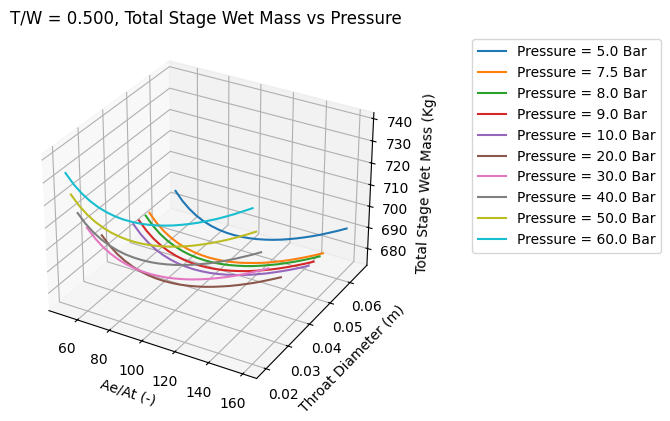

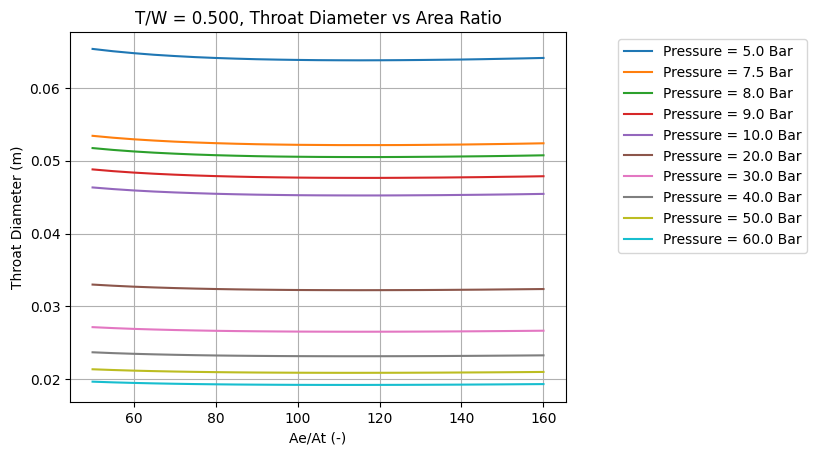

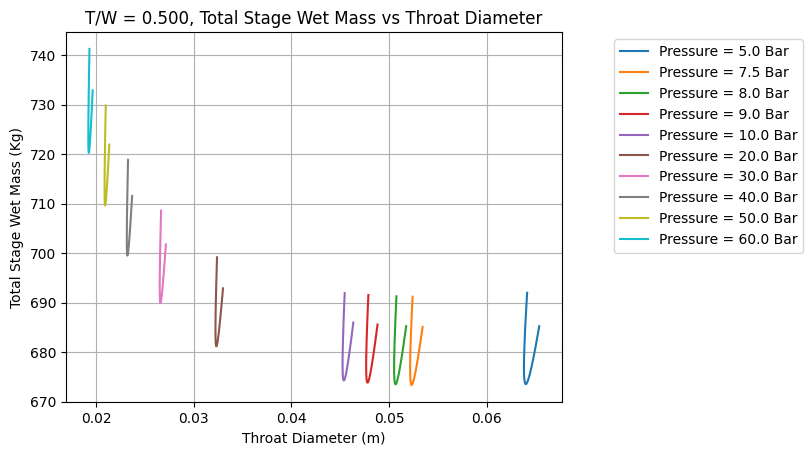

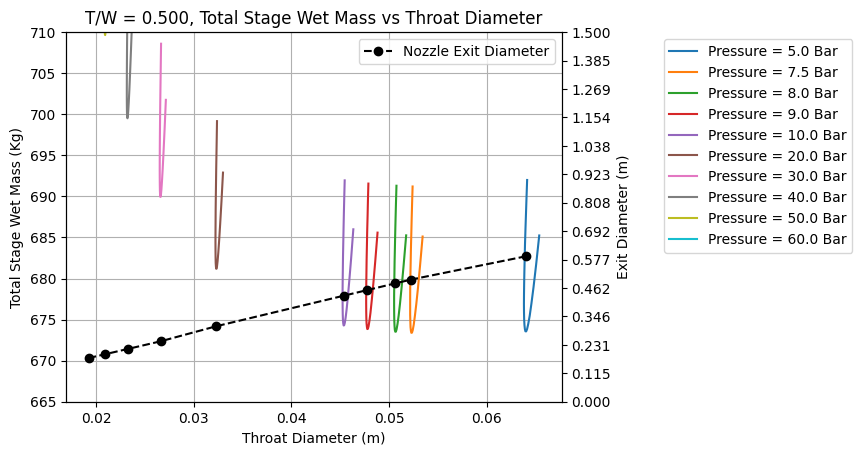

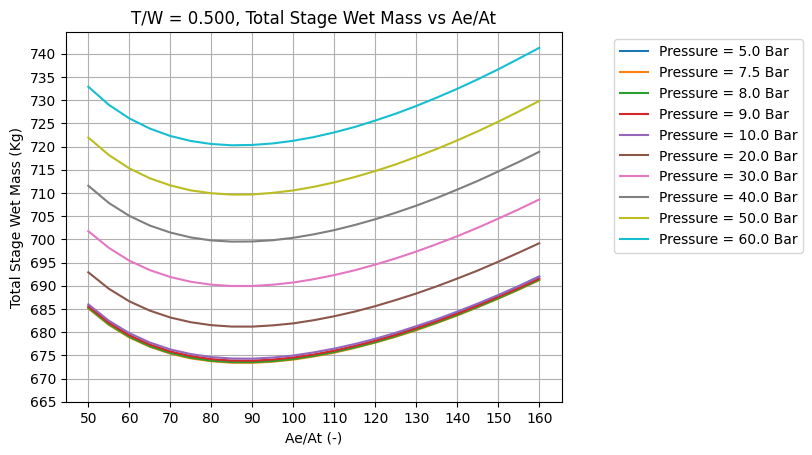

[673.5656316558492, 673.3852708007366, 673.5200867193469, 673.844233293422, 674.2794321282777, 681.190047550067, 689.9390277864527, 699.5118203380712, 709.6394260806379, 720.2731777214615]


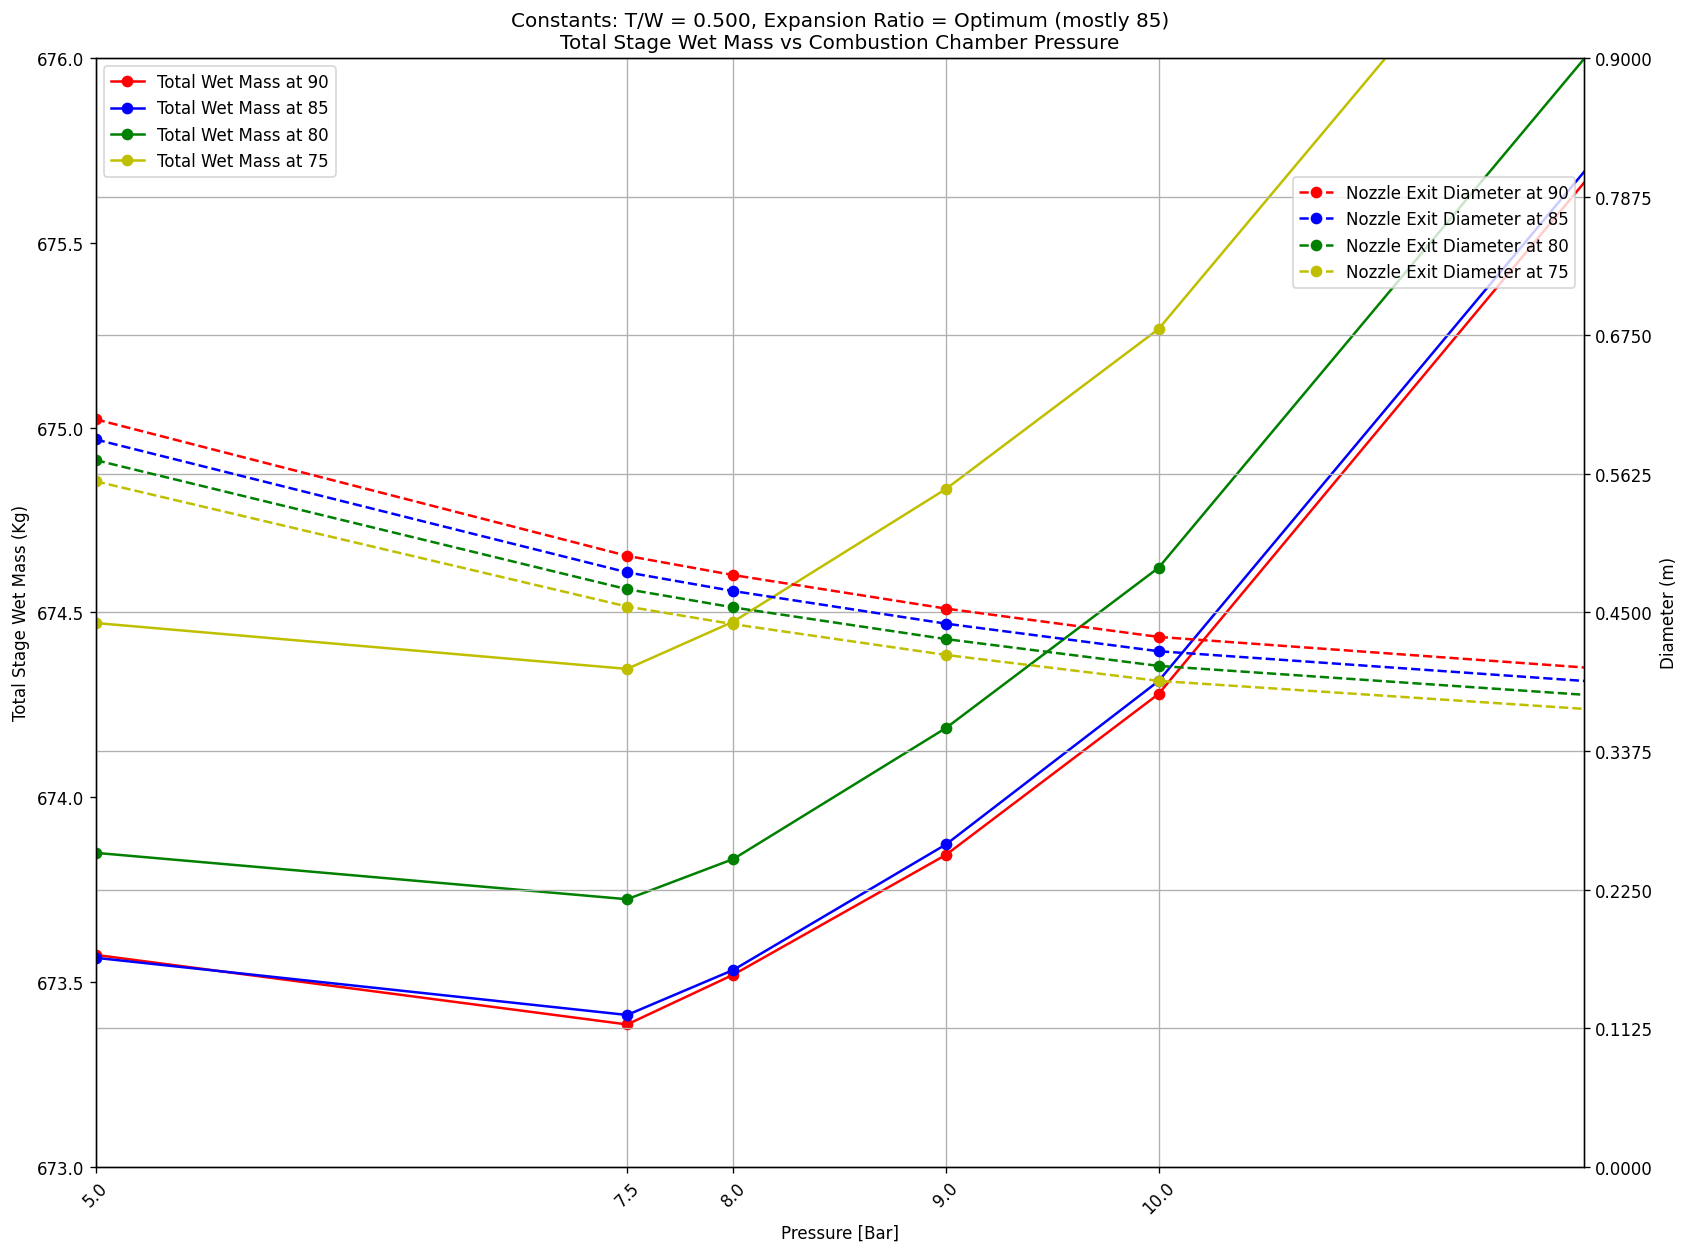

In [28]:

#print(Rocket_Performance_Library[10e5]['dt'])
#print(Rocket_Performance_Library[10e5]['wet_mass'])


#3D Chart
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in Pressure_Keys:
    
    # Make data.
    X = np.array(nozzle_expansion_ratio0)
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(X, Y, Z, label='Pressure = ' + str(i/1e5) + ' Bar' )
    
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1))
plt.title('T/W = 0.500, Total Stage Wet Mass vs Pressure')
plt.xlabel('Ae/At (-)')
plt.ylabel('Throat Diameter (m)')
ax.set_zlabel('Total Stage Wet Mass (Kg)')
plt.show()

#Throat Diameter vs Area Ratio
fig = plt.figure()
ax = fig.add_subplot(111)

for i in Pressure_Keys:
    
    # Make data.
    X = np.array(nozzle_expansion_ratio0)
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(X, Y, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title('T/W = 0.500, Throat Diameter vs Area Ratio')
plt.xlabel('Ae/At (-)')
plt.ylabel('Throat Diameter (m)')
#plt.gca().set_aspect(5000)
plt.grid()
plt.show()


#Total Wet Mass vs Throat Diameter
fig = plt.figure()
ax = fig.add_subplot(111)

for i in Pressure_Keys:
    
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(Y, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title('T/W = 0.500, Total Stage Wet Mass vs Throat Diameter')
plt.xlabel('Throat Diameter (m)')
plt.ylabel('Total Stage Wet Mass (Kg)')
plt.grid()
plt.show()

#Total Wet Mass vs Throat Diameter ZOOMED
fig = plt.figure()
ax = fig.add_subplot(111)

Dt = []
count = 0
for i in Pressure_Keys:
    Dt.append(Rocket_Performance_Library[i]['dt'][local_min_index[count]])
    count += 1
#Dt = [0.146666135002613, 0.09317758690360858, 0.06605601318585663, 0.05400992113743822, 0.046816168877520846, 0.03316796672401447, 0.027106376900970404, 0.023488241438720907, 0.021016293343071965, 0.01919078663249976]

De  = np.sqrt(np.array(Dt)**2*[nozzle_expansion_ratio0[i] for i in local_min_index])
#De = [1.27016599,0.77957962,0.55266426,0.45187942,0.39169217,0.27750312,0.22678822,0.19651673,0.17583493,0.16056164]

#min_mass = [695.2646877041357, 694.8725157368589, 695.1525683801979, 695.2996252200584, 695.3639827518718, 695.2611314095342, 695.0338218526499, 694.8419933135727, 694.6517157157984, 694.5153019334359]
#dt_list = []
#label_list = []
for i in Pressure_Keys:
    
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(Y, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    #ax.plot(Dt[i],min_mass[i],'o', label='Pressure = ' + str(Pressure_Keys[i]/1e5) + ' Bar')
    #dt_list.append(Rocket_Performance_Library[Pressure_Keys[i]]['dt'])
    #label_list.append('Pressure = ' + str(i/1e5) + ' Bar')

#ax.plot(dt_list,min_mass,'ro-')
ax.set_xlabel('Throat Diameter (m)')
ax.set_ylabel('Total Stage Wet Mass (Kg)')

ax.set_ylim([665,710])

ax2 = ax.twinx()
ax2.plot(Dt, De, '--ok', label = 'Nozzle Exit Diameter')
ax2.set_ylabel('Exit Diameter (m)')
ax2.set_yticks(np.linspace(0,1.5,14))

ax.legend(loc='upper right', bbox_to_anchor=(1.6,1))
ax2.legend()
plt.title('T/W = 0.500, Total Stage Wet Mass vs Throat Diameter')

ax.grid()
plt.show()

#Total Wet Mass vs Area Ratio
fig = plt.figure()
ax = fig.add_subplot(111)

for i in Pressure_Keys:
    
    # Make data.
    X = np.array(nozzle_expansion_ratio0)
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(X, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title('T/W = 0.500, Total Stage Wet Mass vs Ae/At')
plt.xlabel('Ae/At (-)')
plt.ylabel('Total Stage Wet Mass (Kg)')
plt.grid()
plt.xticks(range(50,170,10))
plt.yticks(range(665,745,5))
plt.show()


#Total Wet Mass vs Throat Diameter ZOOMED (Lightest Only)
fig = plt.figure(figsize=(16, 12), dpi=120)
ax = fig.add_subplot(111)

#Dt = [0.146666135002613, 0.09317758690360858, 0.06605601318585663, 0.05400992113743822, 0.046816168877520846, 0.03316796672401447, 0.027106376900970404, 0.023488241438720907, 0.021016293343071965, 0.01919078663249976]
#De = [1.27016599,0.77957962,0.55266426,0.45187942,0.39169217,0.27750312,0.22678822,0.19651673,0.17583493,0.16056164]

min_mass = [Rocket_Performance_Library[Pressure_Keys[i]]['wet_mass'][local_min_index[i]] for i in range(len(Pressure_Keys))]
print(min_mass)
#min_mass = [695.2646877041357, 694.8725157368589, 695.1525683801979, 695.2996252200584, 695.3639827518718, 695.2611314095342, 695.0338218526499, 694.8419933135727, 694.6517157157984, 694.5153019334359]
dt_list = []
label_list = []

#ax.plot(np.array(Pressure_Keys)/1e5,min_mass,'-or', label='Total Wet Mass at 85')
ax.plot(np.array(Pressure_Keys)/1e5,[Rocket_Performance_Library[Pressure_Keys[i]]['wet_mass'][8] for i in range(len(Pressure_Keys))],'-or', label=f'Total Wet Mass at {nozzle_expansion_ratio0[8]}')
ax.plot(np.array(Pressure_Keys)/1e5,[Rocket_Performance_Library[Pressure_Keys[i]]['wet_mass'][7] for i in range(len(Pressure_Keys))],'-ob', label=f'Total Wet Mass at {nozzle_expansion_ratio0[7]}')
ax.plot(np.array(Pressure_Keys)/1e5,[Rocket_Performance_Library[Pressure_Keys[i]]['wet_mass'][6] for i in range(len(Pressure_Keys))],'-og', label=f'Total Wet Mass at {nozzle_expansion_ratio0[6]}')
ax.plot(np.array(Pressure_Keys)/1e5,[Rocket_Performance_Library[Pressure_Keys[i]]['wet_mass'][5] for i in range(len(Pressure_Keys))],'-oy', label=f'Total Wet Mass at {nozzle_expansion_ratio0[5]}')

#ax.plot(dt_list,min_mass,'ro-')
ax.set_xlabel('Pressure [Bar]')
ax.set_xticks([5,7.5,8.0,9.0,10.0,20,30,40,50,60])
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylabel('Total Stage Wet Mass (Kg)')
ax.set_ylim([673,676])
ax.set_xlim([5,12])

ax2 = ax.twinx()
#ax2.plot(np.array(Pressure_Keys)/1e5, Dt, '--ok', label='Nozzle Throat Diameter')
#ax2.plot(np.array(Pressure_Keys)/1e5, De, '--or', label='Nozzle Exit Diameter at 85')
ax2.plot(np.array(Pressure_Keys)/1e5, np.sqrt(np.array([Rocket_Performance_Library[Pressure_Keys[i]]['dt'][8] for i in range(len(Pressure_Keys))])**2*nozzle_expansion_ratio0[8]), '--or', label=f'Nozzle Exit Diameter at {nozzle_expansion_ratio0[8]}')
ax2.plot(np.array(Pressure_Keys)/1e5, np.sqrt(np.array([Rocket_Performance_Library[Pressure_Keys[i]]['dt'][7] for i in range(len(Pressure_Keys))])**2*nozzle_expansion_ratio0[7]), '--ob', label=f'Nozzle Exit Diameter at {nozzle_expansion_ratio0[7]}')
ax2.plot(np.array(Pressure_Keys)/1e5, np.sqrt(np.array([Rocket_Performance_Library[Pressure_Keys[i]]['dt'][6] for i in range(len(Pressure_Keys))])**2*nozzle_expansion_ratio0[6]), '--og', label=f'Nozzle Exit Diameter at {nozzle_expansion_ratio0[6]}')
ax2.plot(np.array(Pressure_Keys)/1e5, np.sqrt(np.array([Rocket_Performance_Library[Pressure_Keys[i]]['dt'][5] for i in range(len(Pressure_Keys))])**2*nozzle_expansion_ratio0[5]), '--oy', label=f'Nozzle Exit Diameter at {nozzle_expansion_ratio0[5]}')

ax2.set_ylabel('Diameter (m)')
ax2.set_yticks(np.linspace(0,0.90,9))

plt.title('Constants: T/W = 0.500, Expansion Ratio = Optimum (mostly 85)\nTotal Stage Wet Mass vs Combustion Chamber Pressure')

ax.grid(axis = 'x')
ax2.grid()
ax.legend()
ax2.legend(bbox_to_anchor=(1,0.9))
plt.show()


